In [1]:
import sys
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

np.set_printoptions(threshold=1000)
pd.set_option('display.max_rows', 100)

pp = pprint.PrettyPrinter()

In [2]:
#es = Elasticsearch([{'host': 'hcc-metrics.unl.edu', 'port': 9200}])
username = 'cms'
password = 'B3A96-D0g_PkkPz5'
es = Elasticsearch([{'host': 'es-cms.cern.ch', 'port': 9203, 'http_auth': username+':'+password}], use_ssl=True,verify_certs=True,ca_certs="ca-bundle.trust.crt")

In [3]:
indices = es.cat.indices(index="cms-*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [4]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["cms-*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'cms-', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

In [5]:
# Change second argument to use a different time range for ES queries
no_of_days = 50   # how many days to consider
last_day = 0   # how many days was the last day to consider
# example: no_of_days = 20, last_day = 10 means: use 20 days, up to 10 days ago
ind = time_filter(indices, no_of_days, last_day)
ind = ','.join(ind)

## How to build the aggregation CSV
* Run the aggregations below for different time ranges set using the parameters above, and save them under different file names. For example:
  * last_day = 0
  * no_of_days = 50
  * output_file = 'task_cms_nocpu_50d_1.csv'
  * last_day = 50
  * output_file = 'task_cms_nocpu_50d_2.csv'
  * etc.
* Concatenate the resulting files, taking care of removing the header rows that end up in the body of the concatenated file (keep only the one at the top).

These variables are used:
* **RequestCpus**: number of cores used by the job
* **CpuTimeHr**: CPU time used by the job (system+user), not the one reported by cmsRun (hours). It includes failed attempts. **It must be > 0**
* **CoreHr**: *RemoteWallClockTime* times *RequestCpus*. It includes time spent in failed attempts.  **It must be > 0**
* **WallClockHr**: same as *RemoteWallClockTime* but in hourswall-clock time used by the job (hours), not just on cmsRun
* **CpuEff**: CPU efficiency of the whole job (not just cmsRun), including failed attempts. The same as *CpuTimeHr*/(*WallClockHr* x *RequestCpus*) (%). **It must be <= 100**
* **Kevents**: thousands of events in the job (often not reported by all versions of CMSSW). Derived from *ChirpCMSSWEvents*. **It must be > 0**
* **Type**: type of job (production or analysis)
* **Status**: job status (completed, running, idle, removed, held). **It must be 'completed'**
* **ExitCode**: it is the same as *Chirp_WMCore_cmsRun_ExitCode*. **It must exist**
* **TaskType**: it is either analysis, or it is derived from *WMAgent_TaskType* (production, merge, digireco, repack, reco, cleanup, logcollect, miniaod, express, dataprocessing, gensim, etc.)
* **Site**: site assigned to the job
* **Workflow**: workflow name. Derived either from *CRAB_Workflow* or from *WMAgent_RequestName*
* **InputGB**: amount of data read by job (GB). **It must exist** and it exists only from CMSSW_8_0_0. Derived from *ChirpCMSSWReadBytes*
* **OutputGB**: amount of data written by job (GB). It seems to exist if and only if InputGB exists. Derived from *ChirpCMSSWWriteBytes*
* **WMAgent_SubTaskName**: subtask name for production jobs, used as "task identifier"
* **CRAB_Workflow**: task name for an analysis job
* **MemoryMB**: RSS used by the job (MB) (from HTCondor's ResidentSetSize_RAW)

In [ ]:
# Query for production jobs

s1 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "filter": [
                        {
                            "match": {
                                "Type": "production"
                            }
                        },
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "KEvents": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CpuEff": {"le": 100.}
                            }
                        },
                        {
                            "exists": {
                                "field": "InputGB"
                            }
                        },
                        {
                            "exists": {
                                "field": "ExitCode"
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "wf": {
                            "terms": {
                                "field": "WMAgent_SubTaskName",
                                "size": 100000
                            },
                            "aggs": {
                                "type": {
                                    "terms": {
                                        "field": "Type",
                                        "size": 10
                                    },
                                    "aggs": {
                                        "exitcode": {
                                            "terms": {
                                                "field": "ExitCode",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "loc": {
                                                    "terms": {
                                                        "field": "InputData",
                                                        "size": 1000
                                                    },
                                                    "aggs": {
                                                        "1": {
                                                            "extended_stats": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['CpuTimeHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "2": {
                                                            "extended_stats": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['CoreHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "3": {
                                                            "stats": {
                                                                "field": "CpuTimeHr"
                                                            }
                                                        },
                                                        "4": {
                                                            "extended_stats": {
                                                                "field": "CoreHr"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "RequestCpus"
                                                            }
                                                        },
                                                        "7": {
                                                            "stats": {
                                                                "field": "ChirpCMSSWEvents"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "field": "CpuEff"
                                                            }
                                                        },
                                                        "9": {
                                                            "avg": {
                                                                "script": "doc['MemoryMB'].value / doc['RequestCpus'].value",   # average RAM per core
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "10": {
                                                            "stats": {
                                                                "field": "InputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "11": {
                                                            "stats": {
                                                                "field": "OutputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "12": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['InputGB'].value / doc['KEvents'].value : 0",   # average input data (MB) per event 
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "13": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['OutputGB'].value / doc['KEvents'].value : 0",   # average output data (MB) per event
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "14": {
                                                            "avg": {
                                                                "script": "doc['CoreHr'].value > 0 ? doc['InputGB'].value / (doc['CoreHr'].value * 3.6) : 0",   # average input data rate per thread
                                                                "lang": "expression"
                                                            },
                                                        },
                                                        "15": {
                                                            "avg": {
                                                                "script": "doc['CoreHr'].value > 0 ? doc['OutputGB'].value / (doc['CoreHr'].value * 3.6) : 0",   # average output data rate per thread
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "16": {
                                                            "avg": {
                                                                "field": "CompletionDate"
                                                            }
                                                        },
                                                        "17": {
                                                            "stats": {
                                                                "field": "RemoteWallClockTime"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res1 = es.search(index=ind, body=s1, request_timeout=12000)

In [ ]:
# Query for analysis jobs

s2 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "filter": [
                        {
                            "match": {
                                "Type": "analysis"
                            }
                        },
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "KEvents": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CpuEff": {"le": 100.}
                            }
                        },
                        {
                            "exists": {
                                "field": "InputGB"
                            }
                        },
                        {
                            "exists": {
                                "field": "ExitCode"
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "wf": {
                            "terms": {
                                "field": "CRAB_Workflow",
                                "size": 100000
                            },
                            "aggs": {
                                "type": {
                                    "terms": {
                                        "field": "Type",
                                        "size": 10
                                    },
                                    "aggs": {
                                        "exitcode": {
                                            "terms": {
                                                "field": "ExitCode",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "loc": {
                                                    "terms": {
                                                        "field": "InputData",
                                                        "size": 1000
                                                    },
                                                    "aggs": {
                                                        "1": {
                                                            "extended_stats": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['CpuTimeHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "2": {
                                                            "extended_stats": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['CoreHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "3": {
                                                            "stats": {
                                                                "field": "CpuTimeHr"
                                                            }
                                                        },
                                                        "4": {
                                                            "extended_stats": {
                                                                "field": "CoreHr"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "RequestCpus"
                                                            }
                                                        },
                                                        "7": {
                                                            "stats": {
                                                                "field": "ChirpCMSSWEvents"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "field": "CpuEff"
                                                            }
                                                        },
                                                        "9": {
                                                            "avg": {
                                                                "script": "doc['MemoryMB'].value / doc['RequestCpus'].value",   # average RAM per core
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "10": {
                                                            "stats": {
                                                                "field": "InputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "11": {
                                                            "stats": {
                                                                "field": "OutputGB"   # average input data per job and total input data per task
                                                            }
                                                        },
                                                        "12": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['InputGB'].value / doc['KEvents'].value : 0",   # average input data (MB) per event 
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "13": {
                                                            "avg": {
                                                                "script": "doc['KEvents'].value > 0 ? doc['OutputGB'].value / doc['KEvents'].value : 0",   # average output data (MB) per event
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "14": {
                                                            "avg": {
                                                                "script": "doc['CoreHr'].value > 0 ? doc['InputGB'].value / (doc['CoreHr'].value * 3.6) : 0",   # average input data rate per thread
                                                                "lang": "expression"
                                                            },
                                                        },
                                                        "15": {
                                                            "avg": {
                                                                "script": "doc['CoreHr'].value > 0 ? doc['OutputGB'].value / (doc['CoreHr'].value * 3.6) : 0",   # average output data rate per thread
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "16": {
                                                            "avg": {
                                                                "field": "CompletionDate"
                                                            }
                                                        },
                                                        "17": {
                                                            "stats": {
                                                                "field": "RemoteWallClockTime"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res2 = es.search(index=ind, body=s2, request_timeout=12000)

In [6]:
output_file = 'task_cms_nocpu_50d_1.csv'

In [ ]:
names = ['task', 'tasktype', 'site', 'type', 'exitcode', 'locality', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms',
         'cpu', 'cpu_avg', 'wc', 'wc_avg', 'wc_rms', 'cores', 'evts', 'evts_avg', 'eff', 'ramcore', 'input', 'input_avg',
         'output', 'output_avg', 'inevt', 'outevt', 'inrate', 'outrate', 'date', 'rwct', 'rwct_avg']

with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(names)
    for res in (res1, res2):
        buckets1 = res['aggregations']['ttypes']['buckets']
        for b1 in buckets1:
            ttype = b1['key']
            buckets2 = b1['site']['buckets']
            for b2 in buckets2:
                site = b2['key']
                buckets3 = b2['wf']['buckets']
                for b3 in buckets3:
                    wf = b3['key']
                    buckets4 = b3['type']['buckets']
                    for b4 in buckets4:
                        typ = b4['key']
                        buckets5 = b4['exitcode']['buckets']
                        for b5 in buckets5:
                            exitcode = b5['key']
                            buckets6 = b5['loc']['buckets']
                            for b6 in buckets6:
                                loc = b6['key']
                                cnt = b6['doc_count']
                                try:
                                    writer.writerow([
                                        wf,
                                        ttype,
                                        site,
                                        typ,
                                        exitcode,
                                        loc,
                                        cnt,
                                        b6['1']['avg'],             # average of CPU time per event
                                        b6['1']['std_deviation'],   # standard deviation of CPU time per event
                                        b6['2']['avg'],             # average of wall-clock time times cores per event
                                        b6['2']['std_deviation'],   # standard deviation of wall-clock time times cores per event
                                        b6['3']['sum'] * 3600.,     # total CPU time (seconds)
                                        b6['3']['avg'] * 3600.,     # average CPU time (seconds)
                                        b6['4']['sum'] * 3600.,     # total wall-clock time times cores (seconds)
                                        b6['4']['avg'] * 3600.,     # average wall-clock time times cores (seconds)
                                        b6['4']['std_deviation'] * 3600.,     # std of wall-clock time times cores (seconds)
                                        b6['6']['value'],           # cores
                                        b6['7']['sum'],             # events in task
                                        b6['7']['avg'],             # average events in job
                                        b6['8']['value'],           # CPU efficiency (%)
                                        b6['9']['value'],           # Memory usage per core (MB)
                                        b6['10']['sum'] * 1000.,    # Input data per task (MB)
                                        b6['10']['avg'] * 1000.,    # average input data per job (MB)
                                        b6['11']['sum'] * 1000.,    # input data per task (MB)
                                        b6['11']['avg'] * 1000.,    # average output data per job (MB)
                                        b6['12']['value'],          # Input data per event (MB)
                                        b6['13']['value'],          # Output data per event (MB)
                                        b6['14']['value'],          # input data rate (MB/sec)
                                        b6['15']['value'],          # output data rate (MB/sec)
                                        b6['16']['value'],          # date
                                        b6['17']['sum'],            # total wall-clock time (seconds)
                                        b6['17']['avg']             # average job duration (seconds)
                                    ])
                                except:
                                    print b6['4']['std_deviation']

In [7]:
input_file = 'task_cms_nocpu.csv'

In [8]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, low_memory=False)

In [9]:
df[:5]

,task,tasktype,site,type,exitcode,locality,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,...,input,input_avg,output,output_avg,inevt,outevt,inrate,outrate,date,rwct
0,/mcremone_task_exo-runiisummer15wmlhegs-04804_...,digi,t1_us_fnal,production,0,Onsite,43964,89.181647,33.045630,302.957047,...,2.606395e+07,592.847484,1.456893e+07,331.383226,4.013169,2.243266,0.014098,0.007880,1.503946e+12,490109732.0
1,/pdmvserv_task_top-runiisummer15wmlhegs-00223_...,digi,t1_us_fnal,production,0,Onsite,19934,9.632327,1.880198,12.573881,...,2.282878e+07,1145.218149,1.418358e+07,711.527084,3.029692,1.882356,0.251585,0.156355,1.495657e+12,23641802.0
2,/pdmvserv_task_top-runiisummer15wmlhegs-00223_...,digi,t1_us_fnal,production,0,Offsite,9649,9.462625,2.116614,15.512545,...,1.103515e+07,1143.657508,6.866650e+06,711.643713,3.025566,1.882666,0.216515,0.134738,1.495666e+12,14302089.0
3,/pdmvserv_task_top-runiisummer15wmlhegs-00223_...,digi,t1_us_fnal,production,85,Offsite,21,12.764154,6.008960,77.179895,...,1.069679e+04,509.370764,6.397548e+03,304.645158,3.317267,1.730777,0.130601,0.077232,1.495650e+12,19381.0
4,/pdmvserv_task_top-runiisummer15wmlhegs-00223_...,digi,t1_us_fnal,production,85,Onsite,2,10.592479,1.641392,16.265077,...,1.488711e+03,744.355361,9.129028e+02,456.451398,3.035722,1.845709,0.193956,0.118327,1.495639e+12,2006.0


## Preliminary data exploration

In [10]:
grouped = df.groupby(['tasktype'], as_index=False)
a = grouped.agg({'task': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'evts': 'sum',           # ok!
                 'inrate': 'mean'
                })
a.sort_values('wc', ascending=False)[:20]

,tasktype,inrate,cpuevt_avg,task,wc,cores,wallevt_avg,evts,njobs
16,analysis,0.635289,6.423983,179819,6.185935e+11,1.126925,52.235067,4.377777e+12,77867530
34,digi,0.532253,51.315271,14429,2.734735e+11,3.955932,326.383523,1.648167e+10,18065077
192,gensim,0.504021,150.194389,1104,2.261107e+11,2.931379,278.420582,1.624797e+11,8744942
322,reco,0.073577,30.253917,20408,1.839623e+11,4.212252,59.758248,1.432517e+10,17822821
83,digireco,0.372028,118.795776,3711,1.248854e+11,3.892520,519.522334,4.153544e+09,5848479
33,dataprocessing,0.051707,50.786424,925,7.429523e+10,4.050779,341.354620,1.297914e+10,1711386
251,miniaod,0.138243,2.097279,17667,2.543267e+10,3.969930,4.595996,1.253161e+10,3076155
231,merge,4.580434,0.258752,103603,7.324134e+09,1.000000,1.878745,6.852476e+10,4561026
166,express,0.099682,5.452620,1256,3.153311e+09,8.000000,36.513357,4.547587e+08,228564
480,task1,0.214414,12.305632,688,2.209754e+09,2.510870,17.950646,4.119362e+08,118599


## Average number  of jobs in task

380.830716151


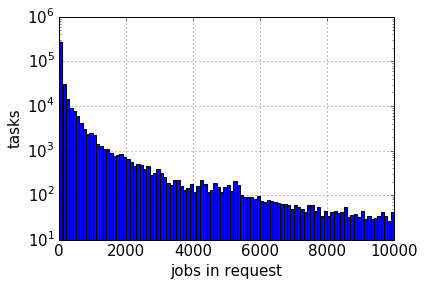

In [11]:
plt.rcParams.update({'font.size': 15})
grouped = df.groupby(['task'], as_index=False)
a = grouped['njobs'].sum()
print np.mean(a['njobs'])
fig = a['njobs'].hist(bins=100, log=True, range=[0., 10000.])
plt.xlabel('jobs in request')
plt.ylabel('tasks')

## Average duration of jobs in task

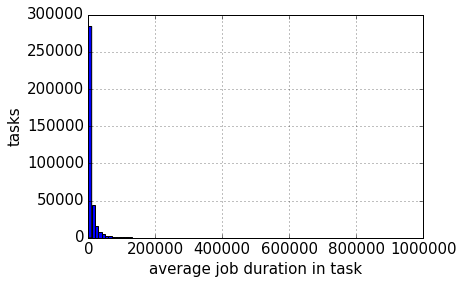

In [12]:
grouped = df.groupby(['task'], as_index=False)
a = grouped['wc_avg'].mean()
fig = a['wc_avg'].hist(bins=100, log=False, range=(0., 1e6))
plt.xlabel('average job duration in task')
plt.ylabel('tasks')

## Average number of events in task

100000.0


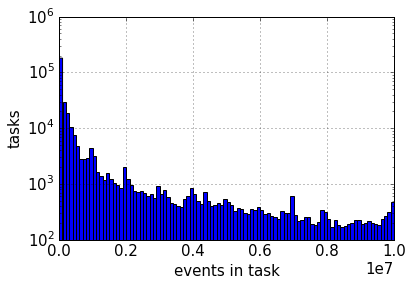

In [13]:
grouped = df.groupby(['task'], as_index=False)
a = grouped['evts'].sum()
print np.median(a['evts'])
fig = a['evts'].hist(bins=100, log=True, range=(0., 1e7))
plt.xlabel('events in task')
plt.ylabel('tasks')

## Average CPU efficiency of tasks

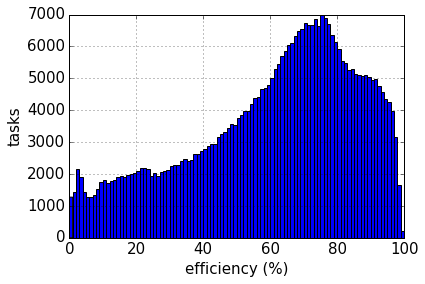

In [14]:
grouped = df.groupby(['task'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=100, log=False, range=(0, 100))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency (%)')
plt.ylabel('tasks')

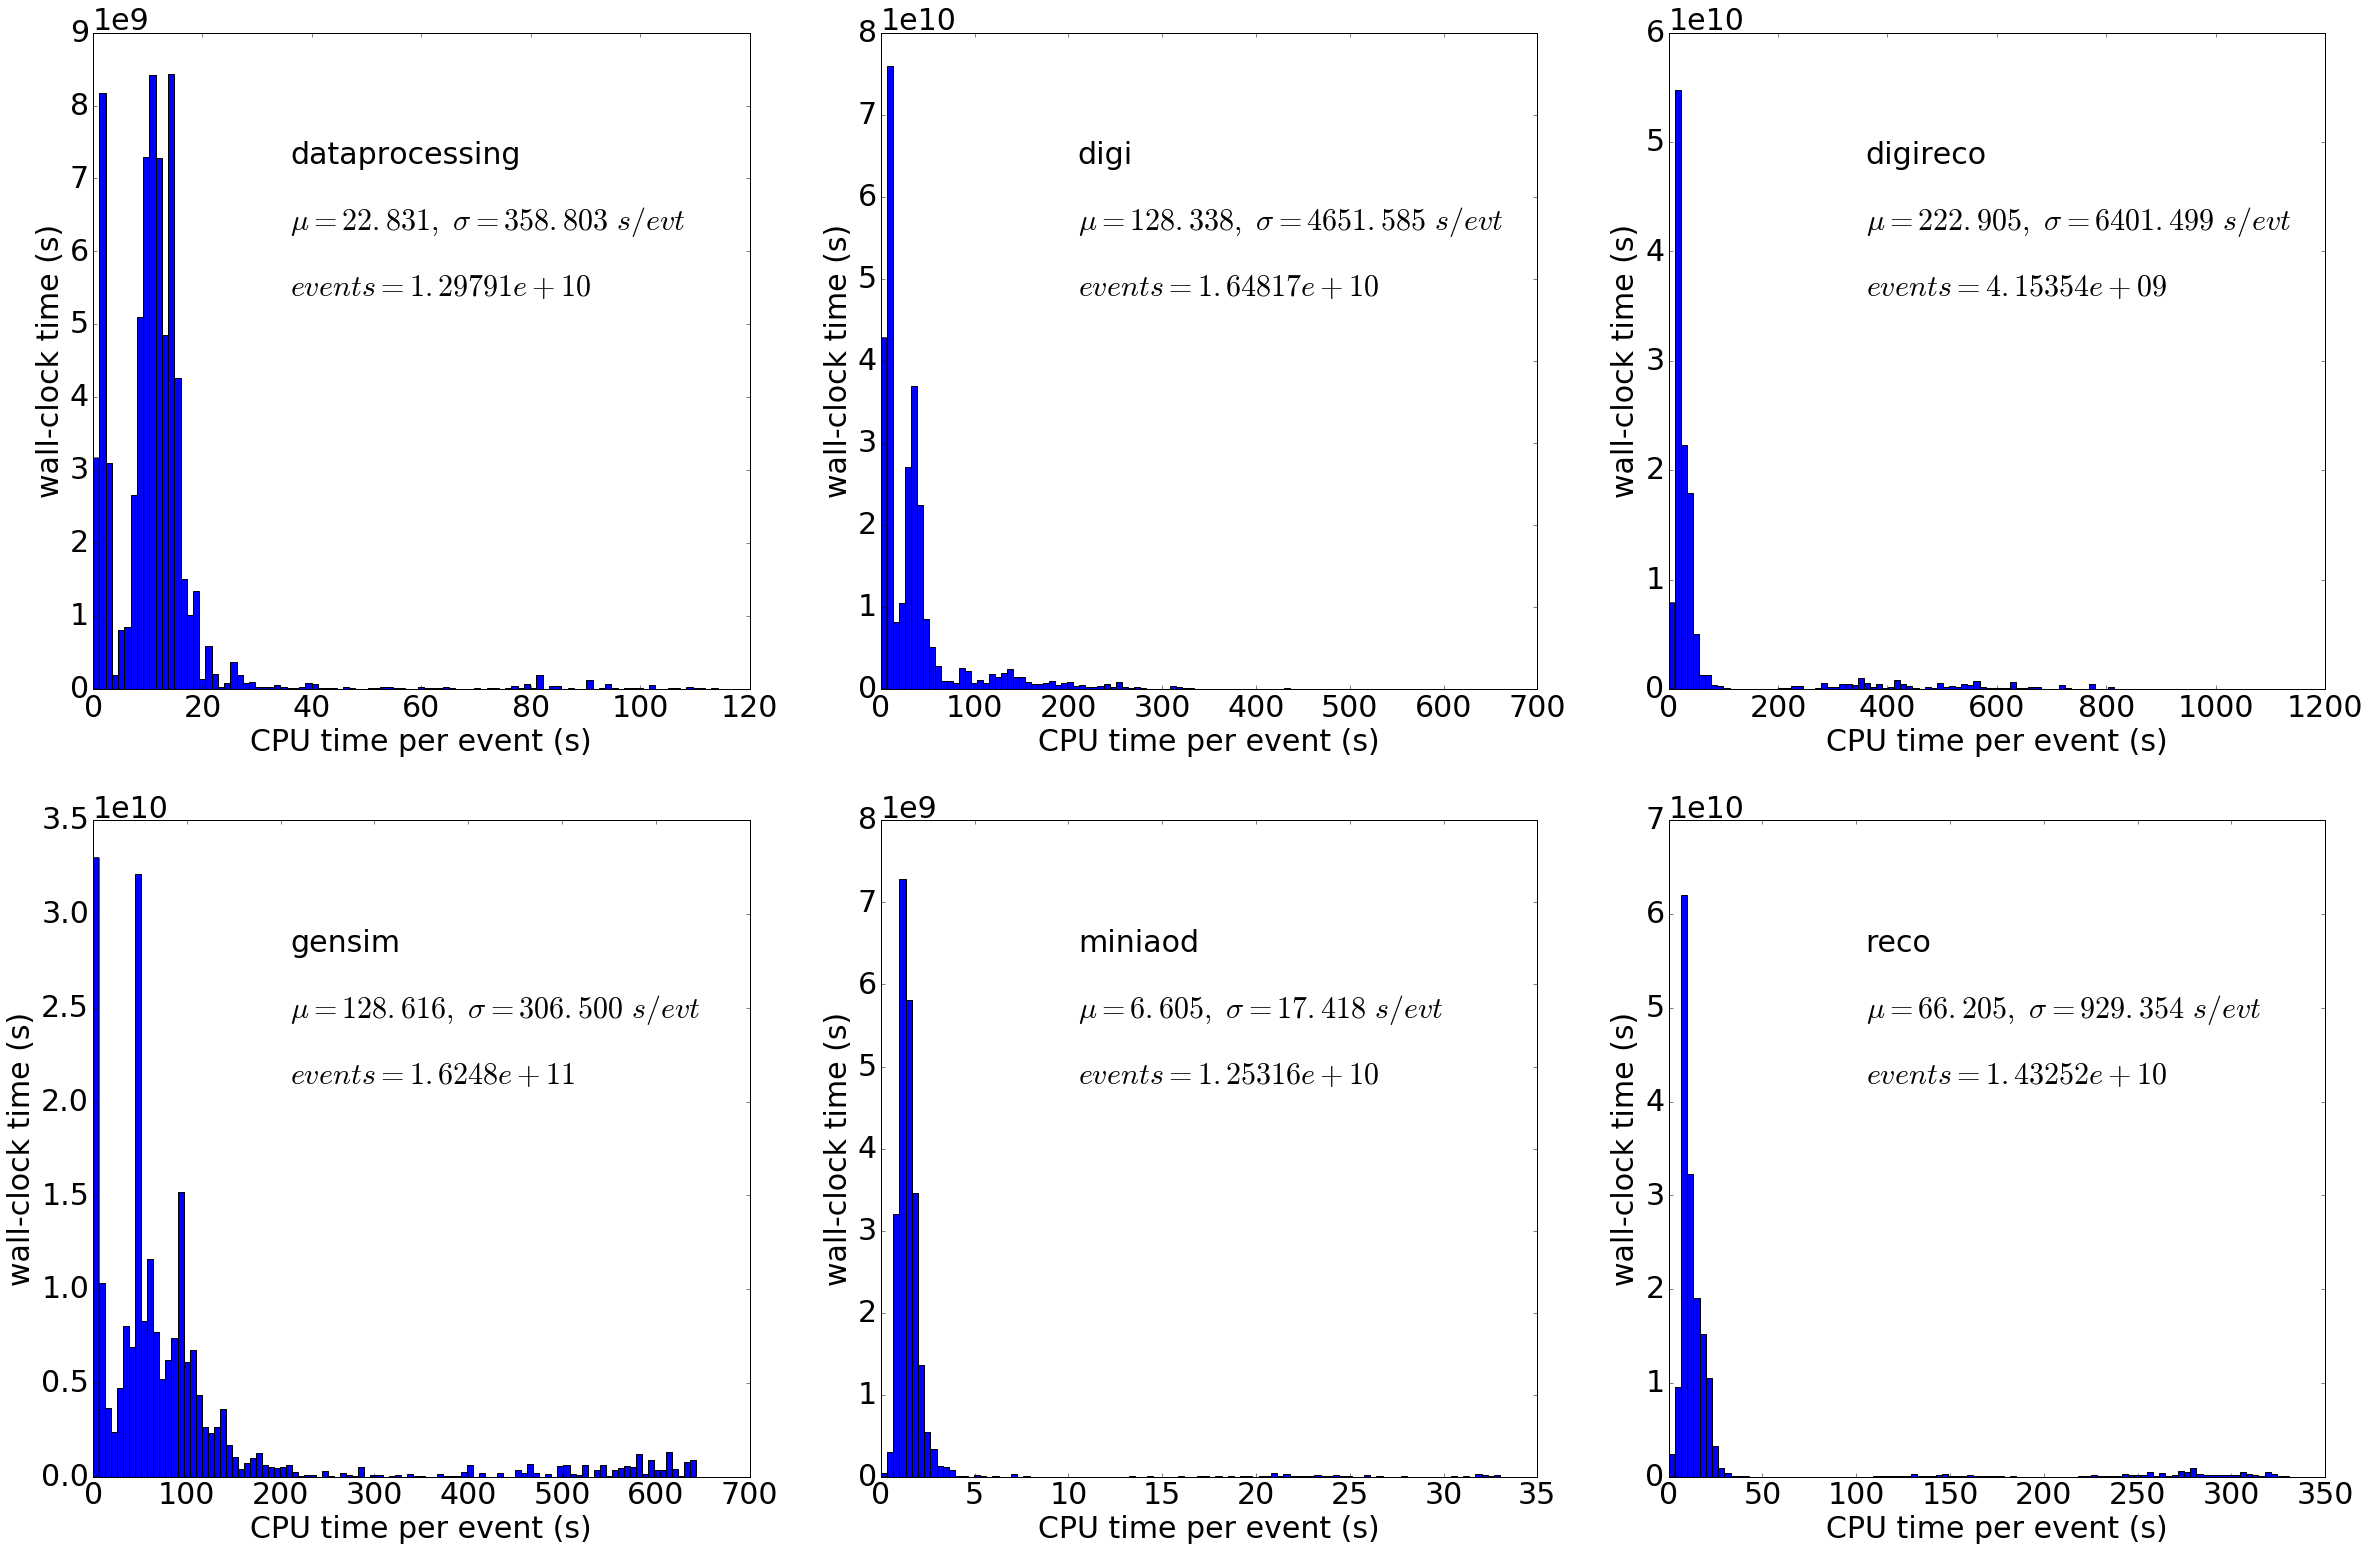

In [15]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['tasktype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.02 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    rg = [0., mean + min(mean, std) * 4.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=rg, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.3), t_y(.8), p)
        plt.text(t_x(.3), t_y(.7), stats)
        plt.text(t_x(.3), t_y(.6), stats2)
    i += 1

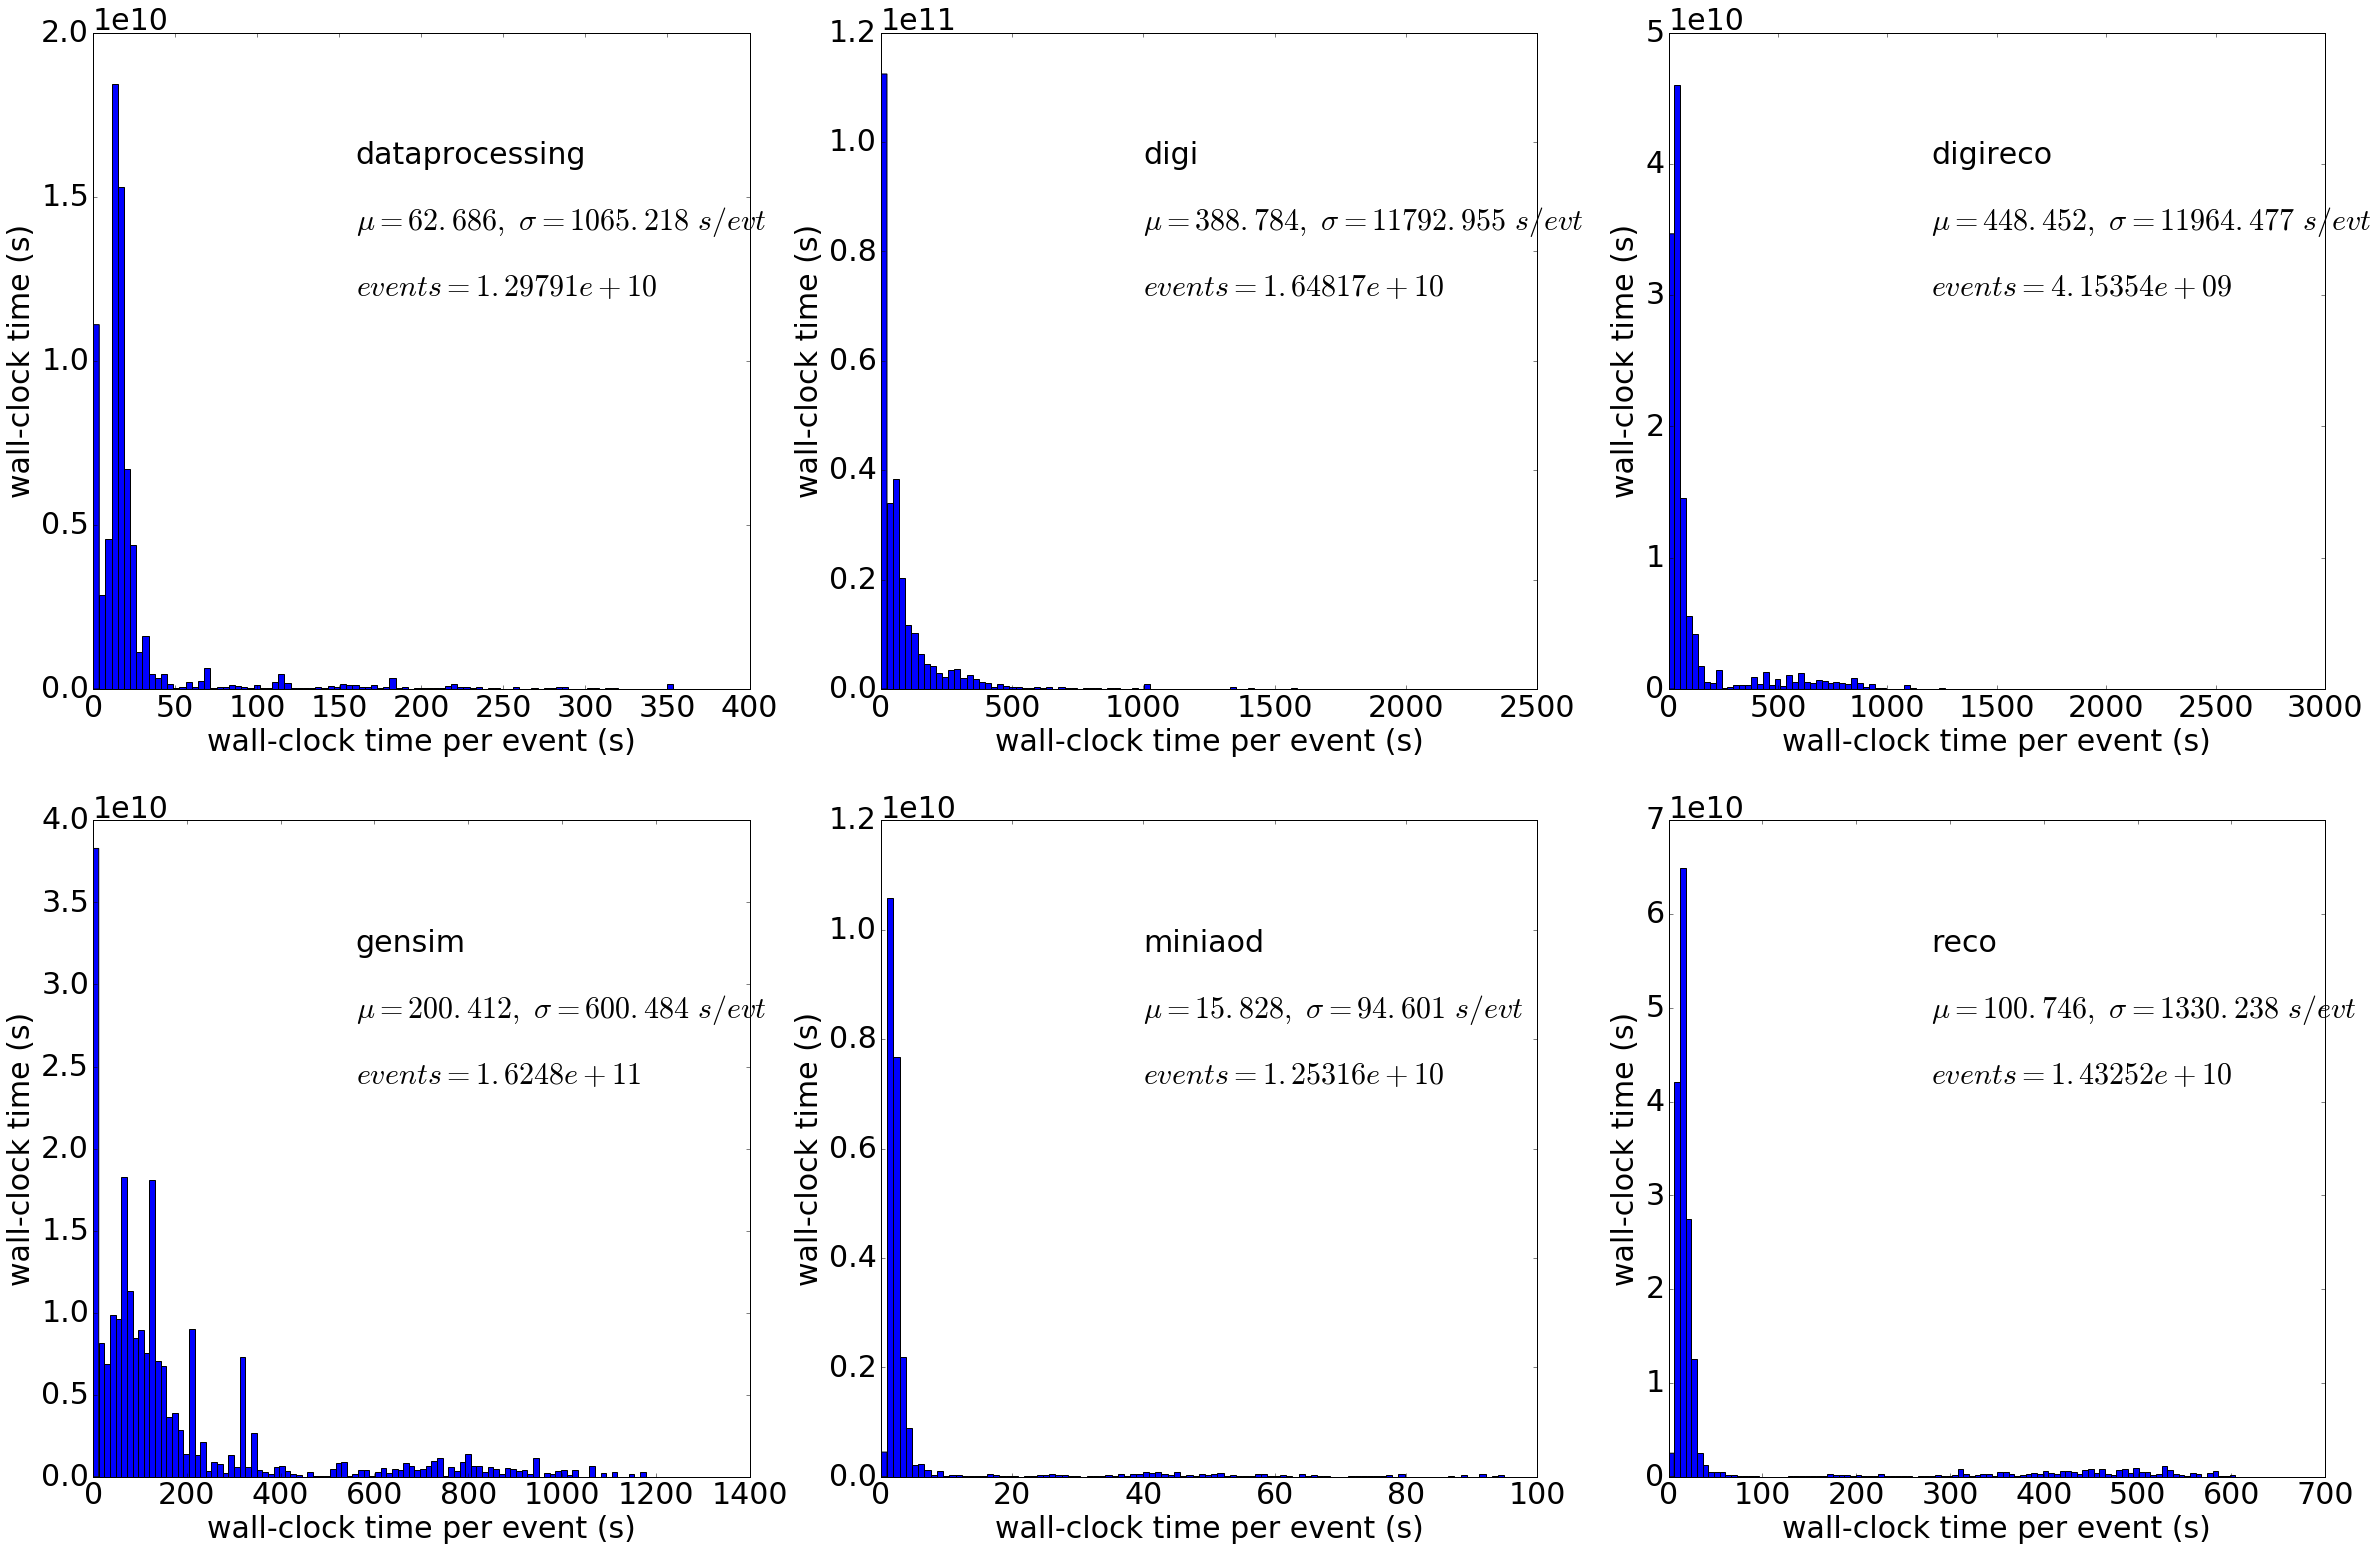

In [16]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['tasktype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.02 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + min(mean, std) * 5.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

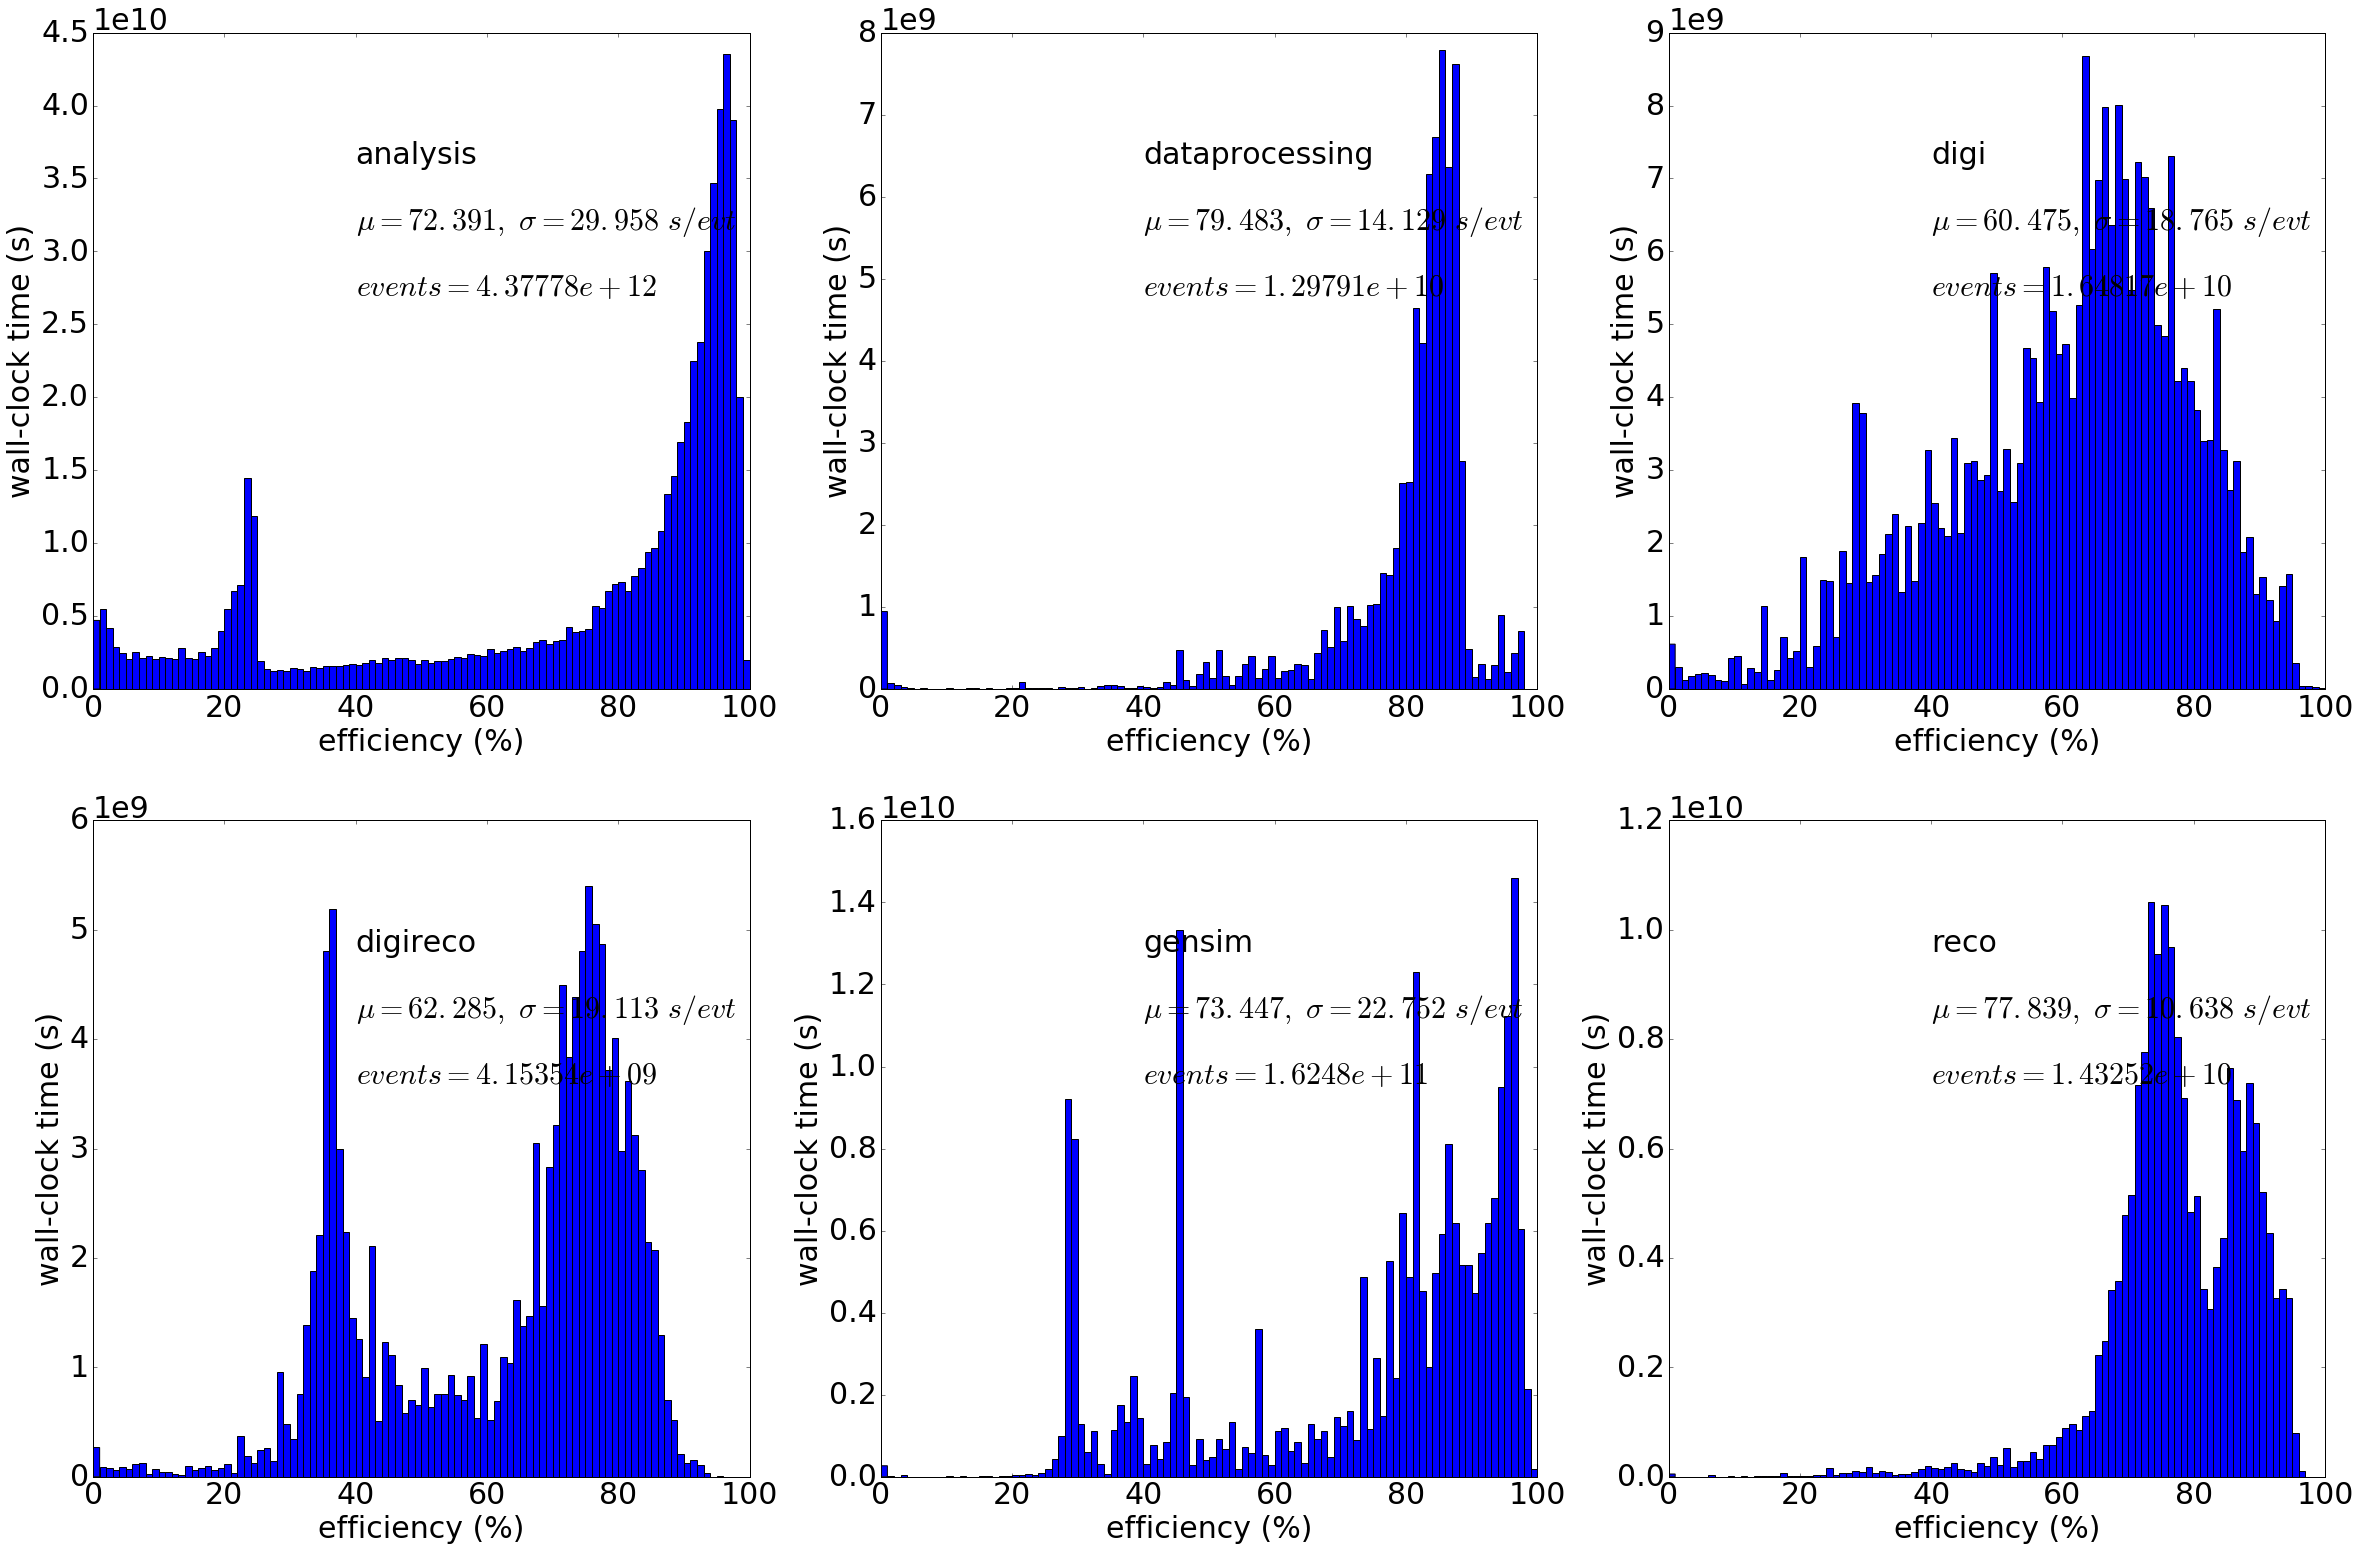

In [17]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['tasktype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.02 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 100.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('efficiency (%)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1